In [6]:
import os
import json
import re
import collections
data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [2]:
contexts = []

for key in wiki.keys() :
    data = wiki[key]
    context = data['text']
    contexts.append(context)

In [3]:
print('Data Size : %d' %len(contexts))

Data Size : 60613


In [4]:
print('Original Text \n')
contexts[0]

Original Text 



'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

## Preprocessing 1

In [7]:
re.sub(r'\n|\\n', '' , contexts[0])

'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.두 목록은 모두 가나다 순이다.일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

## Check UNK Characters

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [9]:
import sys
sys.path.append('../')

In [10]:
import logging
import os
import sys
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

In [11]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer
from retrieval import SparseRetrieval

from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

In [12]:
model_args = ModelArguments

config = AutoConfig.from_pretrained(
    model_args.config_name 
    if model_args.config_name is not None
    else model_args.model_name_or_path,
)

# -- Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name is not None
    else model_args.model_name_or_path,
    # 'use_fast' argument를 True로 설정할 경우 rust로 구현된 tokenizer를 사용할 수 있습니다.
    # False로 설정할 경우 python으로 구현된 tokenizer를 사용할 수 있으며,
    # rust version이 비교적 속도가 빠릅니다.
    use_fast=True,
)
 

In [13]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [14]:
unk_id = tokenizer.convert_tokens_to_ids('[UNK]')

In [15]:
unk_words = []

for i , con in enumerate(tqdm(contexts)) :
    sen_list = sent_tokenize(con)
    for sen in sen_list :
        word_list = word_tokenize(sen)
        for word in word_list :
            if unk_id in tokenizer.encode(word) :
                unk_words.append((i,word))
            

100%|██████████| 60613/60613 [15:20<00:00, 65.85it/s]


In [16]:
print('Size of Words which make UNK Token : %d' %len(unk_words))

Size of Words which make UNK Token : 202639


In [17]:
for i in range(20,40) :
    print(unk_words[i])

(12, '펩타이드')
(13, '平仮名')
(13, 'ひらがな')
(13, 'おんなで')
(13, 'ㄸ+한자')
(13, 'ㅃ+한자')
(14, 'π의')
(15, 'Fourier級數')
(17, '統計')
(17, '슌친')
(17, '柳川春三')
(17, '統計司')
(17, '統計寮')
(19, '全數調査')
(19, '標本調査')
(24, '自然哲學-')
(24, '핼리도')
(24, '핼리도')
(24, '핼리')
(25, '大測')


In [27]:
unk_chars = []

for word in unk_words :
    for ch in word[1] :
        if tokenizer.convert_tokens_to_ids(ch) == unk_id :
            unk_chars.append(ch)

unk_codes = [ord(ch) for ch in unk_chars]
unk_code_plt = [code for code in unk_codes if code < 80000]

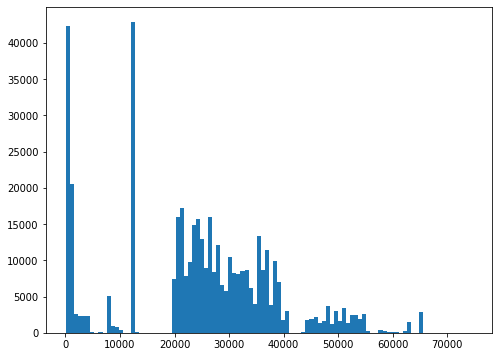

In [54]:
plt.figure(figsize = (8,6))
plt.hist(unk_code_plt, bins=100)
plt.show()

In [58]:
isinstance(tokenizer, BertTokenizerFast)

NameError: name 'BertTokenizerFast' is not defined